In [1]:
from random import random, choices, randint
from collections import Counter
from scipy.stats import binom
from statistics import mean,stdev, variance
import matplotlib.pyplot as plt
from numpy import sqrt, power
from copy import deepcopy
import numpy as np

In [2]:
#org and genome classes

class Genome:
    def __init__(self,sites,genomeLength):
        if sites is None:
            self.sites = self.initSites(genomeLength)
            self.length = genomeLength
        else:
            self.sites = sites
            self.length = len(sites)
          
        
    def initSites(self,genomeLength):
        # all zeroes; good for sawtooth or max-1
        return [0 for _ in range(genomeLength)]

    
    
class Organism:
    def __init__(self,genome,genomeLength,ancesterID = -1):
        if genome is None:
            self.genome = Genome(None,genomeLength)
        else:
            self.genome = genome
        self.offspringCount = 0
        self.fitness = None
        self.ancesterID = ancesterID
            
    
    def makeMutatedCopy(self,):
        global MU
        self.offspringCount += 1
        
        newOrganism = Organism(deepcopy(self.genome),self.genome.length)
        newOrganism.ancesterID = self.ancesterID
        for i in range(newOrganism.genome.length):
            if random() <= MU:
                sign = 1 if random() <= 0.5 else -1
                newOrganism.genome.sites[i] += sign
        return newOrganism
    
    
    def getFitness(self,evalFunc):
        if self.fitness is None:
            self.fitness = evalFunc(self)
        return self.fitness

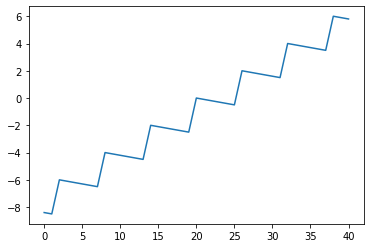

In [3]:
#fitness function and selection algorithms
def sawtooth(organism,plot=False):
    w = 5 #valley width
    d = 0.5 #valley depth
    r = 2 #fitness rise peak to peak
    
    if plot:
        anon = lambda v: v*(-d/w) + (v//(w+1))*(r + d + (d/w))
        plt.plot([anon(v) for v in range(-20,21)])
        plt.show()
        return
    
    x = sum(organism.genome.sites)
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w))

sawtooth(None,plot=True)

def constFitness(organism):
    return 1

def linearFitness(organism):
    x = sum(organism.genome.sites)
#     return (2/5)*x
    return x

def tournament(population,size=2):
    global EVAL_FUNC
    return max(choices(population,k=size),key=lambda org: org.getFitness(EVAL_FUNC))

def roulette_select(population,batchSize,exp=1.05):
    global POP_SIZE, EVAL_FUNC
    MAX = max([org.getFitness(EVAL_FUNC) for org in population])
    F = [ power(exp,org.getFitness(EVAL_FUNC)-MAX) for org in population]
    S = sum(F)
    return choices(list(range(POP_SIZE)),k=batchSize,weights=[f/S for f in F])

def onePeak(organism):
    x = sum(organism.genome.sites)
#     return -(x**2)
#     return 2*x if x < 0 else -0.5*x
    return -abs(x)

def linearFitness4(organism):
    x = sum(organism.genome.sites)
#     return (2/5)*x
    return x**3


def onePeak4(organism):
    x = sum(organism.genome.sites)
#     return -(x**2)
#     return 2*x if x < 0 else -0.5*x
    return -(x**2)

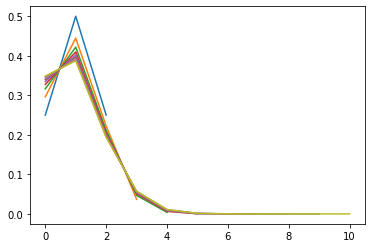

In [4]:
#selection strength components
DR = {}
def getDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]

for testPopSize in [2,3,4,5,6,7,8,9,10]:
    plt.plot(getDriftReference(testPopSize,testPopSize)[:15])
# plt.yscale("log")
plt.show()


def getSigThreshold(DR,p=0.05):
    probVal = 1.0
    index_i = 0
    while probVal > p:
        probVal -= DR[index_i]
        index_i += 1
    return index_i


# MDR = {}
def moranDriftReference(N,maxOffCount,plot=False):
#     if N not in MDR:
    z = (N-1)/(2*N-1)
    gtr1 = lambda n: (N/(N-1))**2 * (z)**(n+1)
#         MDR[N] = [z if n==0 else gtr1(n) for n in range(maxOffCount+1)]
    if plot:
        return [z if n==0 else gtr1(n) for n in range(maxOffCount+1)]
    return [z if n==0 else gtr1(n) for n in range(max(N,maxOffCount)+1)] # MDR[N]


def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])


# def getSS(offCounts_1d,initialPop,finalPop):
#     Counts = Counter(offCounts_1d)
#     Observed = [Counts[x]/initialPop if x in Counts else 0 for x in range(finalPop+1)]
#     return emd(getDriftReference(initialPop,finalPop),Observed)

def getSS(offCounts_1d):
    Counts = Counter(offCounts_1d)
    N_init = int(sum(Counts.values()))
    N_final = sum([int(k)*int(v) for k,v in Counts.items()])
    Observed = [Counts[x]/N_init if x in Counts else 0 for x in range(N_final+1)]
    return emd(getDriftReference(N_init,N_final),Observed)


def getSSMoran(offCounts_1d,N):
    Counts = Counter(offCounts_1d)
    Observed = [Counts[x]/N if x in Counts else 0 for x in range(max(N,max(Counts.keys()))+1)]
#     print("cnt",Counts)
#     print("obs",Observed)
#     print("ref",moranDriftReference(N,max(Counts.keys())))
    return emd(moranDriftReference(N,max(Counts.keys())),Observed)


def dictionaryReduce(listOfDict,target={}):
    #NOTE: if the target and listOfDict both lack a key,
    #      the updated target will not contain an entry for that key:
    #      this function aims to include zeros for missing keys
    #      therefore, some entries may lack zeros if they are not 
    #      represented in the initial set of keys provided; this function is
    #      best used when listOfDict is the final set of dics to be reduced
    maxKey = max([max(d.keys()) for d in listOfDict]+[max(list(target.keys())+[-1])])
    for dic in listOfDict:
        for key in range(maxKey+1):
            if key not in target:
                target[key] = []
            target[key].append(dic[key])
    return target

In [9]:
#parameters

POP_SIZE = 1000
GENOME_LENGTH = 1
MU = 1/8 #1.0/(2.5*(GENOME_LENGTH))
GENERATIONS = 5000
TSIZE = 2
REXP = float(10)

# EVAL_FUNC = sawtooth
EVAL_FUNC = constFitness
# EVAL_FUNC = linearFitness
# EVAL_FUNC = onePeak

In [6]:
# basic WF theory confirmation

population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
dataLog = []
offCountAcc = {}

for generation in range(GENERATIONS):
    print(int(100*generation/GENERATIONS),"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    
    #tournament
#     newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
    #roulette
    newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
    
    offspringCounts = Counter([org.offspringCount for org in population])
    ##
#     maxCount = max(offspringCounts.keys())
#     valueBins = []
#     for xxx in range(maxCount):
#         valueBins.append(mean([org.genome.sites[0] for org in population if org.offspringCount == xxx])
#                         if offspringCounts[xxx] > 0 else None)
#     plt.plot(list(range(maxCount)),valueBins,marker="o")
#     plt.show()
    ##
    
    offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
    
    selectionStrength = getSS(offspringCounts)
    
    dataLog.append((aveFitness,selectionStrength))
    population = newPopulation
print()
    
aveFitLog, selStrLog = list(zip(*dataLog))


/home/vincent/.local/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


99 %


0.024152056344591916 0.010527288068375872


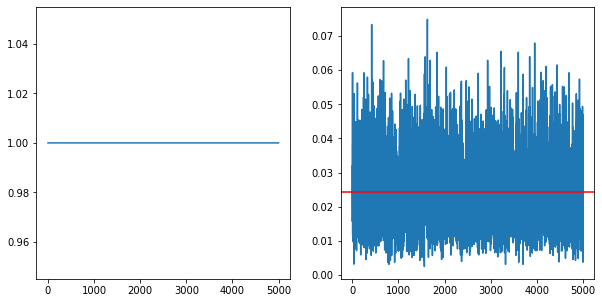

checkSum (1.0) 1.0
Larger than 5 offspring is signifigantly more than expected by drift.


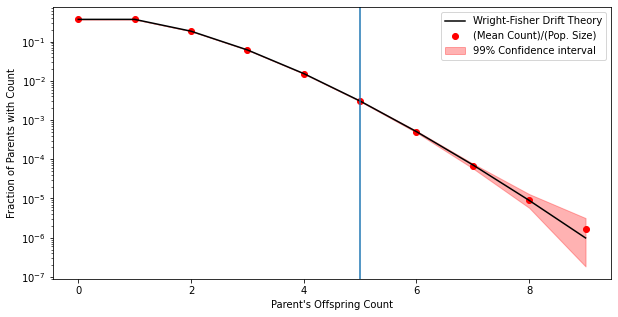

In [7]:
#plot WF results
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(aveFitLog)
axs[1].plot(selStrLog)
print(mean(selStrLog),stdev(selStrLog))
axs[1].axhline(mean(selStrLog),color="r")
plt.show()


print("checkSum (1.0)", sum([sum(V) for V in offCountAcc.values()]) / (GENERATIONS*POP_SIZE) )
meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc.items()}
stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc.items()}

plt.figure(figsize=(10,5))
plt.plot(getDriftReference(POP_SIZE,POP_SIZE)[:max(offCountAcc.keys())+1],
         label="Wright-Fisher Drift Theory",color="k")

sigthresh = getSigThreshold(getDriftReference(POP_SIZE,POP_SIZE),p=0.01)
print("Larger than",sigthresh,
      "offspring is signifigantly more than expected by drift.")
plt.axvline(sigthresh)
plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")

plt.fill_between(sorted(stdvDict.keys()),
                 [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 alpha=0.3,color="r",label="99% Confidence interval")
plt.legend()
plt.title("")
plt.xlabel("Parent's Offspring Count")
plt.ylabel("Fraction of Parents with Count")
plt.yscale("log")
plt.show()

In [8]:
# basic MORAN theory confirmation

population = [Organism(None,GENOME_LENGTH,ancesterID = i) for i in range(POP_SIZE)]
aveFitLog = []
deathLog = []
ancesterListLog = []

for update in range(GENERATIONS*POP_SIZE):
    if update % POP_SIZE == 0:
        #log ancesterIDs
        ancesterListLog.append([org.ancesterID for org in population])
        #reset ancesterIDs
        for i in range(POP_SIZE):
            population[i].ancesterID = i
        
#     print(  (100*update)/(GENERATIONS*POP_SIZE)  ,"%",end="\r")
        aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
        aveFitLog.append(aveFitness)
        
        
#     child = tournament(population,size=TSIZE).makeMutatedCopy()
    child = population[roulette_select(population,1,exp=REXP)[0]].makeMutatedCopy()
    
    deathID = randint(0,POP_SIZE-1)
    deathLog.append(deepcopy(population[deathID]))
    population[deathID] = child
#     population = [org for i,org in enumerate(population) if i != deathID] + [child]
    
    
print()


KeyboardInterrupt: 

In [ ]:
##plot moran results
plt.figure(figsize=(10,5))
plt.plot(aveFitLog)
plt.show()

selStrLog = []
offCountAcc = {}

debugPlotSet = []

for i in range(GENERATIONS):
    deathGen = deathLog[i*POP_SIZE:(i+1)*POP_SIZE]
    offspringCounts = Counter([org.offspringCount for org in deathGen])
    selectionStrength = getSSMoran(offspringCounts,POP_SIZE)
    selStrLog.append(selectionStrength)
    offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
    
#     print("Dist Below has SS:",selectionStrength)
#     plt.hist([org.offspringCount for org in deathGen])
#     plt.plot(np.multiply(POP_SIZE,moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=True)),marker="o",label="Moran Drift Theory",color="k")
#     plt.show()
    debugPlotSet.append((selectionStrength,
                         tuple([org.offspringCount for org in deathGen]),
                         tuple(np.multiply(POP_SIZE,
                                           moranDriftReference(POP_SIZE, max(offspringCounts.keys()),plot=True)))))
selStrLogP = []
debugPlotSetP = []
prob_moran = 1
thrsh_geq_moran = 0
tempMoranDR = moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=False)
while prob_moran > 0.01:
    prob_moran -= tempMoranDR[thrsh_geq_moran]
    thrsh_geq_moran += 1
print("offspring geq", thrsh_geq_moran, "larger than expected",prob_moran)
for i in range(GENERATIONS):
    deathGen = deathLog[i*POP_SIZE:(i+1)*POP_SIZE]
    offspringCounts = Counter([org.offspringCount for org in deathGen])
    selectionStrength = sum([1 for org in deathGen if org.offspringCount >= thrsh_geq_moran])
    selStrLogP.append(selectionStrength)
    
#     print("Dist Below has SS:",selectionStrength)
#     plt.hist([org.offspringCount for org in deathGen])
#     plt.plot(np.multiply(POP_SIZE,moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=True)),marker="o",label="Moran Drift Theory",color="k")
#     plt.show()
    debugPlotSetP.append((selectionStrength,
                         tuple([org.offspringCount for org in deathGen]),
                         tuple(np.multiply(POP_SIZE,
                                           moranDriftReference(POP_SIZE, max(offspringCounts.keys()),plot=True)))))


    
    
plt.plot(selStrLog)
plt.show()
print("ave selstr",mean(selStrLog[5:]))
plt.hist(selStrLog)
plt.yscale("log")
plt.show()

# debugPlotSet.sort(reverse=True)
# for entry in debugPlotSet:
#     print("Dist Below has SS:",entry[0])
#     plt.hist(entry[1],bins=[-0.5]+[b+0.5 for b in range(len(entry[2]))])
#     plt.plot(entry[2],marker="o",label="Moran Drift Theory",color="k")
# #     plt.yscale("log")
#     plt.show()

start=0
stop=len(selStrLogP)
win = 10
AVEDATA = [mean(selStrLogP[max(start,i-win):min(i+win+1,stop)]) for i in range(start,stop)] # CORRECTED
plt.plot(selStrLogP,color="k")
plt.plot(AVEDATA,linewidth="2",color="r")
plt.show()

plt.hist(selStrLogP)
plt.yscale("log")
plt.show()

# debugPlotSetP.sort(reverse=True)
# for entry in debugPlotSetP:
#     print("Dist Below has SS:",entry[0])
#     plt.hist(entry[1],bins=[-0.5]+[b+0.5 for b in range(len(entry[2]))])
#     plt.plot(entry[2],marker="o",label="Moran Drift Theory",color="k")
# #     plt.yscale("log")
#     plt.show()



print(mean(selStrLog),stdev(selStrLog))
meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc.items()}
stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc.items()}

plt.figure(figsize=(10,5))
print(max(offCountAcc.keys()))
plt.plot(moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=True),
         label="Moran Drift Theory",color="k")

plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")
plt.axvline(thrsh_geq_moran)
plt.fill_between(sorted(stdvDict.keys()),
                 [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 alpha=0.3,color="r",label="99% Confidence interval")
plt.legend()
plt.title("")
plt.xlabel("Parent's Offspring Count")
plt.ylabel("Fraction of Parents with Count")
plt.yscale("log")
# plt.xlim(-5,20)
plt.show()

##########################
ANCESTER_SS = []
offCountAcc_ANCESTER = {}
for entry in ancesterListLog:
    ancesterCounts = Counter(entry)
    for i in range(POP_SIZE):
        if i not in ancesterCounts.keys():
            ancesterCounts[i]=0
    offspringCounts = Counter(ancesterCounts.values())
    selectionStrength = getSSMoran(offspringCounts,POP_SIZE)
    ANCESTER_SS.append(selectionStrength)
    offCountAcc_ANCESTER = dictionaryReduce([offspringCounts],target=offCountAcc_ANCESTER)
    
plt.plot(ANCESTER_SS)
plt.show()
plt.scatter(selStrLog[2:],ANCESTER_SS[2:])
plt.show()

meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc_ANCESTER.items()}
stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc_ANCESTER.items()}

plt.figure(figsize=(10,5))
print(max(offCountAcc_ANCESTER.keys()))
plt.plot(moranDriftReference(POP_SIZE, max(offCountAcc_ANCESTER.keys()),plot=True),
         label="Moran Drift Theory",color="k")

plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")
# plt.axvline(thrsh_geq_moran)
plt.fill_between(sorted(stdvDict.keys()),
                 [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 alpha=0.3,color="r",label="99% Confidence interval")
plt.legend()
plt.title("")
plt.xlabel("Parent's Offspring Count")
plt.ylabel("Fraction of Parents with Count")
plt.yscale("log")
# plt.xlim(-5,20)
plt.show()


fig, axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(list(range(start,stop)),aveFitLog[start:stop],label="Average Fitness")
# axs[0].plot(list(range(start,stop)),maxData[start:stop],label="Max Fitness")
axs[0].set_ylabel("Fitness Function Score")
axs[0].legend()
axs[1].plot(list(range(start,stop)),ANCESTER_SS[start:stop],color="k",label="Selection Strength")
# axs[1].plot(list(range(start,stop)),AVEDATA,linewidth=2,color="r",label="Traveling Average")
axs[1].set_xlabel("Generations")
axs[1].set_ylabel("EMD($f_D$,$f$)")
# axs[1].legend()
plt.show()

In [10]:
# population size, effects on drift measure

EVAL_FUNC = constFitness
popsizerange = [10,25,50,100,250,500,1000,2500,5000,10000]
popSSlog = []



for EVAL_FUNC in [constFitness, onePeak, linearFitness,onePeak4,linearFitness4]:
    for POP_SIZE in popsizerange:
        print(POP_SIZE)
        population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
        dataLog = []
        offCountAcc = {}

        for generation in range(GENERATIONS):
    #         print(int(100*generation/GENERATIONS),"%",end="\r")
            aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])

            #tournament
#             newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
            #roulette
            newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
            
            offspringCounts = Counter([org.offspringCount for org in population])

            offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)

            selectionStrength = getSS(offspringCounts)

            dataLog.append((aveFitness,selectionStrength))
            population = newPopulation
    
        aveFitLog, selStrLog = list(zip(*dataLog))

        #plot WF results
    #     fig, axs = plt.subplots(1,2,figsize=(10,5))
    #     axs[0].plot(aveFitLog)
    #     axs[1].plot(selStrLog)
        print(mean(selStrLog),stdev(selStrLog))
        popSSlog.append((mean(selStrLog),stdev(selStrLog)))
    #     axs[1].axhline(mean(selStrLog),color="r")
    #     plt.show()
        print()

10
0.22978107109468154 0.09815359414479001

25
0.14746017962934038 0.07026700745912892

50
0.10405404783839985 0.0487585018915596

100
0.07618196064703091 0.0343004889974947

250
0.0480820973749152 0.021653395957971548

500
0.03456205269586558 0.015287245928192063

1000
0.02429886950831645 0.0106653125969654

2500
0.015329320102358575 0.006823157799486922

5000
0.010924715896433804 0.004751359917092425

10000
0.0078260250948795 0.0034522667893569846

10
0.24197403669992146 0.10917486172674701

25
0.15934110055931291 0.07935280604443336

50
0.11950544011497599 0.05751428750411292

100
0.09484324740004801 0.04507743306908177

250
0.07418981099921919 0.03240312318511364

500
0.06643568606931732 0.024805333893854913

1000
0.06317077758421484 0.01883716327417346

2500
0.06107153263302637 0.012431644815461553

5000
0.0610660867517529 0.008967785189476376

10000
0.06081063393735875 0.0063641903496961605

10
0.41987513033928103 0.26812186686107975

25
0.49600776125097357 0.24917349027932126

5

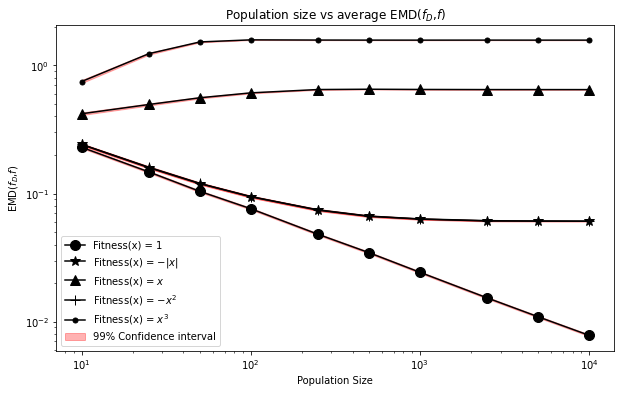

In [12]:
# population size, effects on drift measure (plots)
ssmean, ssstd = list(zip(*popSSlog)) 

plt.figure(figsize=(10,6))
lineLabels = ["Fitness(x) = 1","Fitness(x) = $-|x|$","Fitness(x) = $x$","Fitness(x) = $-x^2$","Fitness(x) = $x^3$"]
lineMarkers = ["o","*","^","+","."]
CIlabels = ["99% Confidence interval","","","",""]
for i in range(5):
    start = i*len(popsizerange)
    stop = (i+1)*len(popsizerange)
    
    plt.plot(popsizerange,ssmean[start:stop],label=lineLabels[i],marker=lineMarkers[i],color="k",markersize=10)
    # plt.plot(popsizerange,ssstd,label="Standard Deviation")
for i in range(5):
    start = i*len(popsizerange)
    stop = (i+1)*len(popsizerange)
    
    plt.fill_between(popsizerange,
                     [m+(2.58*s)/sqrt(GENERATIONS) for m,s in popSSlog[start:stop]],
                     [m-(2.58*s)/sqrt(GENERATIONS) for m,s in popSSlog[start:stop]],
                     alpha=0.3,color="r",label=CIlabels[i])
plt.xlabel("Population Size")
plt.ylabel("EMD($f_D$,$f$)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Population size vs average EMD($f_D$,$f$)")
plt.axhline(0,color="k")
plt.show()

In [12]:
# MUR8, effects on drift measure

murange = [1]+[1/(x*(GENOME_LENGTH*POP_SIZE)) for x in [1/2048,1/1024,1/512,1/256,1/128,1/64,1/32,1/16,1/8,1/4,1/2,1,2,4,8,16,32,64,128] if (x*(GENOME_LENGTH*POP_SIZE)) > 1]
muSSlog = []
POP_SIZE = 500

for EVAL_FUNC in [constFitness, onePeak, linearFitness,onePeak4,linearFitness4]:
    for MU in murange:
        print(MU)
        population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
        dataLog = []
        offCountAcc = {}

        for generation in range(GENERATIONS):
    #         print(int(100*generation/GENERATIONS),"%",end="\r")
            aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])

            #tournament
            newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
            #roulette
#             newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
            
            offspringCounts = Counter([org.offspringCount for org in population])

            offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)

            selectionStrength = getSS(offspringCounts)

            dataLog.append((aveFitness,selectionStrength))
            population = newPopulation
    
        aveFitLog, selStrLog = list(zip(*dataLog))

        #plot WF results
    #     fig, axs = plt.subplots(1,2,figsize=(10,5))
    #     axs[0].plot(aveFitLog)
    #     axs[1].plot(selStrLog)
        print(mean(selStrLog),stdev(selStrLog))
        muSSlog.append((mean(selStrLog),stdev(selStrLog)))
    #     axs[1].axhline(mean(selStrLog),color="r")
    #     plt.show()
        print()

1
0.034284459953150805 0.015118248048478607

0.2048
0.034747701764774076 0.01529000212276154

0.1024
0.03435647101017067 0.015004287410646647

0.0512
0.03479684426106564 0.01518272073015385

0.0256
0.03466171514798326 0.015082091048392894

0.0128
0.034312201661162 0.015135505450544613

0.0064
0.03398235480578551 0.015406697202498734

0.0032
0.034302019788665844 0.015094277704804506

0.0016
0.03424789037143755 0.014920057201907144

0.0008
0.03401245086470481 0.015233951608690085

0.0004
0.03437214352815111 0.015247568599271984

0.0002
0.034372546187865345 0.0150325518935139

0.0001
0.03446913199511413 0.015508853467291474

5e-05
0.034489763556173156 0.015219003256609924

2.5e-05
0.034299725445449035 0.015168019641543063

1.25e-05
0.03446046302807315 0.015213279458764158

6.25e-06
0.03439579403732144 0.015208251687679076

3.125e-06
0.03460134605606683 0.014961293946685937

1.5625e-06
0.03462979072778842 0.015391197890998824

7.8125e-07
0.03402130095604827 0.014922256997269803

1
0.081647

In [ ]:
# MUR8, effects on drift measure (plots)
ssmean, ssstd = list(zip(*muSSlog)) 

plt.figure(figsize=(10,6))
lineLabels = ["Fitness(x) = 1","Fitness(x) = $-|x|$","Fitness(x) = $x$","Fitness(x) = $-x^2$","Fitness(x) = $x^3$"]
lineMarkers = ["o","*","^","+","."]
CIlabels = ["99% Confidence interval","","","",""]
for i in range(5):
    start = i*len(murange)
    stop = (i+1)*len(murange)
    
    plt.plot(murange,ssmean[start:stop],label=lineLabels[i],marker=lineMarkers[i],color="k",markersize=10)
    # plt.plot(popsizerange,ssstd,label="Standard Deviation")
for i in range(5):
    start = i*len(murange)
    stop = (i+1)*len(murange)
    
    plt.fill_between(murange,
                     [m+(2.58*s)/sqrt(GENERATIONS) for m,s in muSSlog[start:stop]],
                     [m-(2.58*s)/sqrt(GENERATIONS) for m,s in muSSlog[start:stop]],
                     alpha=0.3,color="r",label=CIlabels[i])
plt.xlabel("Mutation Rate")
plt.ylabel("EMD($f_D$,$f$)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("mutation rate vs average selection strength")
plt.axhline(0,color="k")
plt.show()

In [ ]:
# WF three tiers of selection

meanSelections = []

funcCounter = 0
for EVAL_FUNC in [constFitness, onePeak, linearFitness]:
    population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
    dataLog = []
    offCountAcc = {}
    for generation in range(GENERATIONS):
        print(funcCounter,int(100*generation/GENERATIONS),"%",end="\r")
        aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
        newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
        offspringCounts = Counter([org.offspringCount for org in population])
        offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
        selectionStrength = getSS(offspringCounts,POP_SIZE,POP_SIZE)
        dataLog.append((aveFitness,selectionStrength))
        population = newPopulation
    print()
    funcCounter += 1
    
    aveFitLog, selStrLog = list(zip(*dataLog))
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].plot(aveFitLog)
    axs[1].plot(selStrLog)
    print(mean(selStrLog),stdev(selStrLog))
    meanSelections.append((mean(selStrLog),stdev(selStrLog)))
    axs[1].axhline(mean(selStrLog),color="r")
    plt.show()
    


In [ ]:
#sawtooth with 3 tiers plotted

meanSelections = []
population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
dataLog = []
offCountAcc = {}
EVAL_FUNC = sawtooth
EVAL_FUNC(None,plot=True)
for generation in range(GENERATIONS):
    print(int(100*generation/GENERATIONS),"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    varFitness = variance([org.getFitness(EVAL_FUNC) for org in population])
    newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
    offspringCounts = Counter([org.offspringCount for org in population])
    offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
    selectionStrength = getSS(offspringCounts,POP_SIZE,POP_SIZE)
    dataLog.append((aveFitness,varFitness,selectionStrength))
    population = newPopulation
print()

aveFitLog, varFitLog, selStrLog = list(zip(*dataLog))



In [ ]:
#plot WF results
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(aveFitLog)
axs[1].plot(selStrLog)
axs[1].axhline(mean(selStrLog),color="m")
for m in meanSelections:
    axs[1].axhline(m[0],color="r")
    axs[1].axhline(m[0]+(2.58*m[1])/sqrt(GENERATIONS),color="g")
    axs[1].axhline(m[0]-(2.58*m[1])/sqrt(GENERATIONS),color="g")
plt.show()

plt.scatter(selStrLog,varFitLog)
plt.xlabel("selection strength")
plt.ylabel("pop variance")
plt.show()

In [ ]:
#plot WF results
start = 2300
stop = 2350

win = 10
AVEDATA = [mean(selStrLog[max(0,i-win):min(i+win+1,stop-start)]) for i in range(stop-start)]

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(list(range(start,stop)),aveFitLog[start:stop])
axs[1].plot(list(range(start,stop)),selStrLog[start:stop])
axs[1].plot(list(range(start,stop)),AVEDATA,linewidth=2.5,color='#55FF55')
# axs[1].axhline(mean(selStrLog[start:stop]),color="y")
for m in meanSelections:
    axs[1].axhline(m[0],color="y")
    axs[1].axhline(m[0]+(2.58*m[1])/sqrt(GENERATIONS),color="r")
    axs[1].axhline(m[0]-(2.58*m[1])/sqrt(GENERATIONS),color="r")
plt.show()